In [1]:
from pycap import PropertyTree,EnergyStorageDevice
input_database=PropertyTree()
input_database.parse_xml('super_capacitor.xml')
# build a supercapacitor
supercapacitor_database=input_database.get_child('device')
supercapacitor=EnergyStorageDevice(supercapacitor_database)
# and its equivalent circuit
equivalent_circuit_database=EnergyStorageDevice.compute_equivalent_circuit(supercapacitor_database)
equivalent_circuit=EnergyStorageDevice(equivalent_circuit_database)

# Compare using Cyclic Charge-Discharge

In [2]:
# setup experiment
from pycap import CyclicChargeDischarge
ptree=PropertyTree()
ptree.put_string('start_with','charge')
ptree.put_int   ('cycles',3)
ptree.put_double('time_step',0.1)
ptree.put_string('charge_mode','constant_current')
ptree.put_double('charge_current',2e-3)
ptree.put_string('charge_stop_at_1','voltage_greater_than')
ptree.put_double('charge_voltage_limit',2.1)
ptree.put_string('discharge_mode','constant_current')
ptree.put_double('discharge_current',4e-3)
ptree.put_string('discharge_stop_at_1','voltage_less_than')
ptree.put_double('discharge_voltage_limit',0.7)
ccd=CyclicChargeDischarge(ptree)

In [3]:
from pycap import initialize_data
# run cyclic charge discharge on both devices
devices={"supercapacitor":supercapacitor,"equivalent_circuit":equivalent_circuit}
results={}
for device_name in devices:
    data=initialize_data()
    ccd.run(devices[device_name],data)
    results[device_name]=data

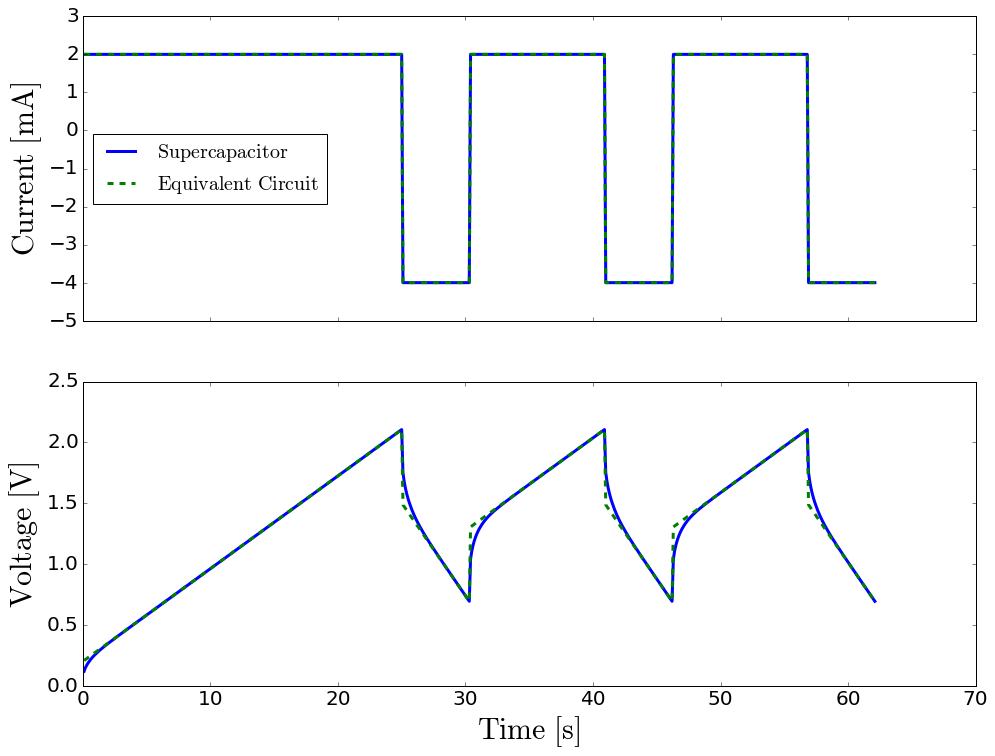

In [4]:
# visualize the results and compare
from matplotlib import pyplot
%matplotlib inline
f,axarr=pyplot.subplots(2,sharex=True,figsize=(16,12))
plot_linewidth=3
label_fontsize=30
tick_fontsize=20
legend_fontsize=20
labels={'supercapacitor':r'$\mathrm{Supercapacitor}$',
        'equivalent_circuit':r'$\mathrm{Equivalent\ Circuit}$'}
line_styles={'supercapacitor':'-b',
             'equivalent_circuit':'--g'}
for device_name in devices:
    data=results[device_name]
    axarr[0].plot(data['time'],1e3*data['current'],
                  line_styles[device_name],
                  lw=plot_linewidth,
                  label=labels[device_name])
    axarr[0].set_ylabel(r'$\mathrm{Current\ [mA]}$',fontsize=label_fontsize)
    axarr[0].get_yaxis().set_tick_params(labelsize=tick_fontsize)
    axarr[0].legend(loc='center left',fontsize=legend_fontsize)
    axarr[1].plot(data['time'],data['voltage'],
                  line_styles[device_name],
                  lw=plot_linewidth,
                  label=labels[device_name])
    axarr[1].set_ylabel(r'$\mathrm{Voltage\  [V]}$',fontsize=label_fontsize)
    axarr[1].set_xlabel(r'$\mathrm{Time\     [s]}$',fontsize=label_fontsize)
    axarr[1].get_xaxis().set_tick_params(labelsize=tick_fontsize)
    axarr[1].get_yaxis().set_tick_params(labelsize=tick_fontsize)

As can be seen from the plot voltage versus time (current is imposed), the equivalent circuit model predicts rather well the behavior of the supercapacitor here. The only discrepancies that are present appear when the operating conditions toggle from charge to discharge. After a short transient, both models are in perfect agreement.

If the charge and discharge rates are reduced (for instance divide the currents by two, i.e. set `charge_current` to $1\ \mathrm{mA}$ and `discharge_current` to $2\ \mathrm{mA}$, and re-run the experiment) the difference between the two charge-discharge curves vanishes. Conversely, higher rates will exacerbate the discrepancies.

# Compare using Electrochemical Impedance Spectroscopy

NOTE: might want to reinitialize device before running EIS
seems the first high frequency points were garbage...

In [5]:
# setup experiment
from pycap import measure_impedance_spectrum
eis_database=PropertyTree()
eis_database.put_double('frequency_upper_limit',1e+2)
eis_database.put_double('frequency_lower_limit',1e-4)
eis_database.put_int   ('steps_per_decade',6)
eis_database.put_int   ('cycles',16)
eis_database.put_int   ('ignore_cycles',8)
eis_database.put_int   ('steps_per_cycle',256)
eis_database.put_double('dc_voltage',0)
eis_database.put_string('harmonics','1')
eis_database.put_string('amplitudes','5e-3')
eis_database.put_string('phases','0')

In [6]:
devices={"supercapacitor":supercapacitor,"equivalent_circuit":equivalent_circuit}
results={}
for device_name in devices:
    results[device_name]=measure_impedance_spectrum(devices[device_name],eis_database)

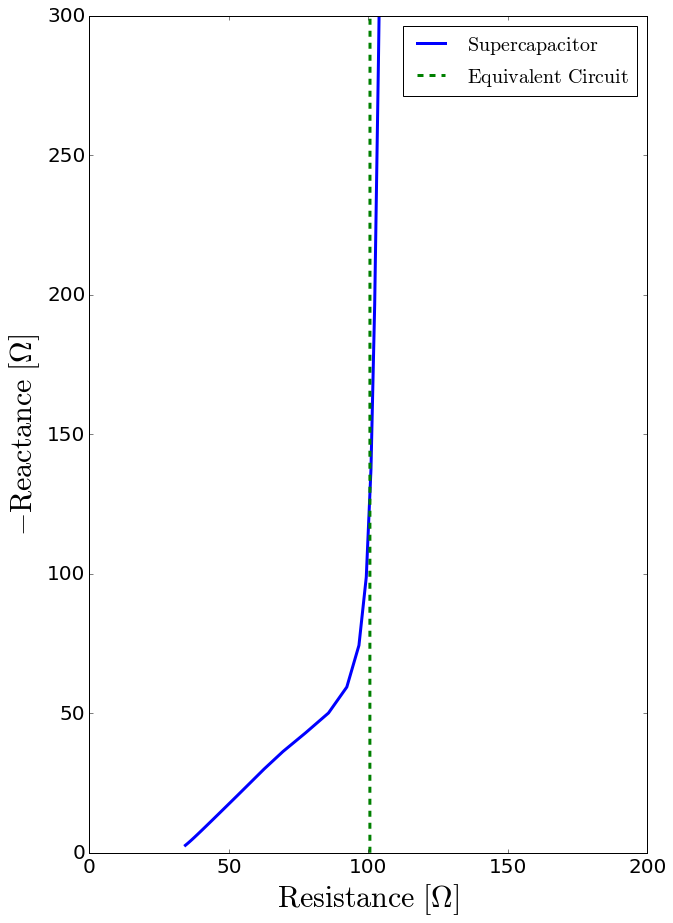

In [7]:
# Nyquist plot
from numpy import real,imag
pyplot.figure(figsize=(10,15))
plot_linewidth=3
label_fontsize=30
tick_fontsize=20
legend_fontsize=20
for device_name in devices:
    impedance=results[device_name]['impedance']
    resistance=real(impedance)
    reactance =imag(impedance)
    pyplot.plot(resistance,-reactance,
                line_styles[device_name],
                lw=plot_linewidth,
                label=labels[device_name])
pyplot.axis('equal')
pyplot.xlabel(r'$\mathrm{Resistance\ [\Omega]}$',fontsize=label_fontsize)
pyplot.ylabel(r'$\mathrm{-Reactance\ [\Omega]}$',fontsize=label_fontsize)
pyplot.gca().xaxis.set_tick_params(labelsize=tick_fontsize)
pyplot.gca().yaxis.set_tick_params(labelsize=tick_fontsize)
pyplot.legend(fontsize=legend_fontsize)
pyplot.xlim(0,200)
pyplot.ylim(0,300)
pyplot.show()

The plot is zoomed on the higher frequencies. Here more than the slight difference in the slope of the two curves towards the top (essentially an artefact), the $45^\circ$ slope on the solid blue line in the bottom should catch the attention.

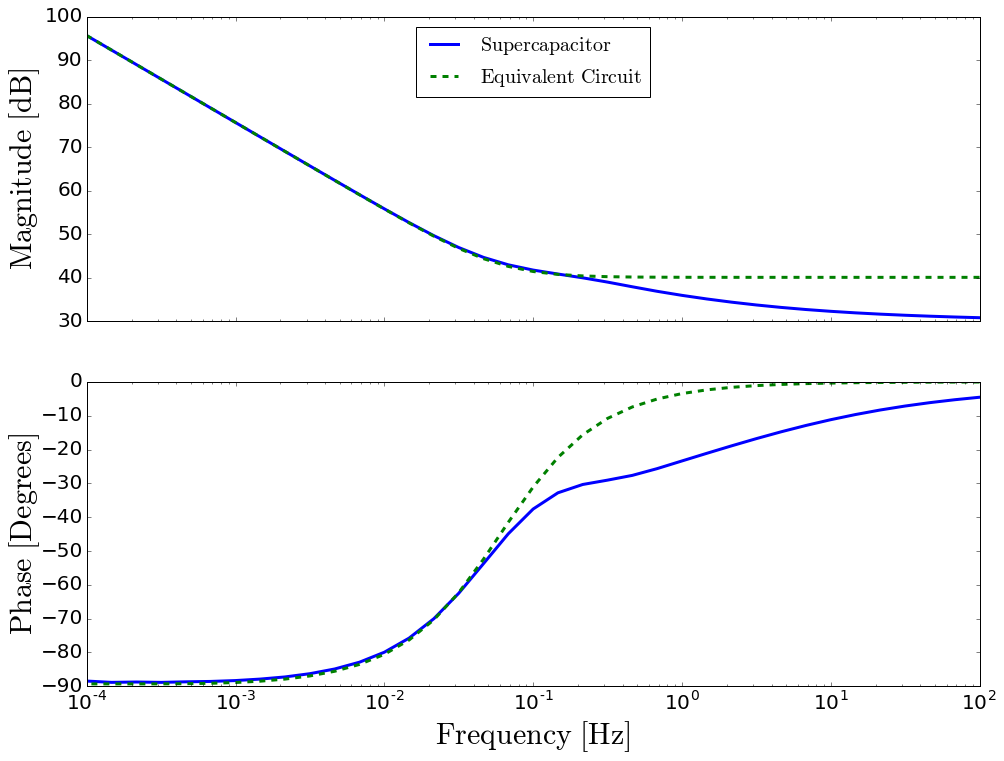

In [8]:
# Bode plot
label_fontsize=30
tick_fontsize=20
legend_fontsize=20
labelx=-0.05
labely=0.5
plot_linewidth=3
f,axarr=pyplot.subplots(2,sharex=True,figsize=(16,12))
from numpy import log10,absolute,angle
for device_name in devices:
    frequency=results[device_name]['frequency']
    impedance=results[device_name]['impedance']
    magnitude=20*log10(absolute(impedance))
    phase=angle(impedance,deg=True)
    axarr[0].plot(frequency,magnitude,
                line_styles[device_name],
                lw=plot_linewidth,
                label=labels[device_name])
    axarr[1].plot(frequency,phase,
                line_styles[device_name],
                lw=plot_linewidth,
                label=labels[device_name])
axarr[0].set_xscale('log')
axarr[0].set_ylabel(r'$\mathrm{Magnitude\ [dB]}$',fontsize=label_fontsize)
axarr[0].get_yaxis().set_tick_params(labelsize=tick_fontsize)
axarr[0].yaxis.set_label_coords(labelx,labely)
axarr[0].legend(loc='upper center',fontsize=legend_fontsize)
axarr[1].set_xscale('log')
axarr[1].set_ylabel(r'$\mathrm{Phase\ [Degrees]}$',fontsize=label_fontsize)
axarr[1].set_xlabel(r'$\mathrm{Frequency\ [Hz]}$',fontsize=label_fontsize)
axarr[1].get_yaxis().set_tick_params(labelsize=tick_fontsize)
axarr[1].get_xaxis().set_tick_params(labelsize=tick_fontsize)
axarr[1].yaxis.set_label_coords(labelx,labely)


Same EIS data as above, different way of look at it. The Bode plot clearly shows that the equivalent circuit model (dashed green line) is not able to reproduce well the behavior of the supercapacitor (solid blue line) for higher frequencies, above $0.1\ \mathrm{Hz}$. This is consistent with what was observed with cyclic charge-discharge.